In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    mean_squared_error, r2_score, classification_report,
    confusion_matrix, accuracy_score, precision_recall_fscore_support
)
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

np.random.seed(42)


file_path = 'Effects of Violent Video Games On Aggression CSV MSDOS.csv'
df = pd.read_csv(file_path)


print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (147, 43)


,Timestamp,What is your age?,Gender,Class,City/ Residencial status,Type of Family,What type of video games do you typically play?,Name the video game you usually play,How many hours do you play Video Games in a day?,"How much time do you play ""violent"" video games specifically?",...,there are people who pushed me so far that we begin fighting,"I know that some so called ""friends"" talk about me behind my back",My friends say that I am a bit argumentative,Sometimes I lose temper for no good reason,I get into fights a little more than a normal person,sometimes I can not control the feeling to hit another person,I sometimes get too much jealous from people,I dont know why sometimes I feel bitter about things,"Have you ever been involved in delinquent behaviour? like stealing, breaking things of others",Do you believe that playing violent video games can lead to aggressive behavior in real life?
0,07/11/2023 22:16,20,male,12th,Lahore,joint,action,Pubg,more than 3 hour,more than 2 hour,...,Agree,Agree,Agree,Strongly disagree,Disagree,NaN,NaN,NaN,no,yes
1,07/11/2023 23:01,18,male,11th,Lahore,joint,action,Pubg,more than 3 hour,more than 2 hour,...,Agree,Agree,Strongly agree,Agree,Agree,Agree,Neither agree nor disagree,Disagree,yes,yes
2,07/11/2023 23:11,16,male,11th,Lahore,nuclear,action,PUBG,more than 1 hour,more than 1 hour,...,Disagree,Neither agree nor disagree,Neither agree nor disagree,Neither agree nor disagree,Disagree,Strongly disagree,Strongly disagree,Disagree,yes,yes
3,07/11/2023 23:12,19,female,12th,Lahore,nuclear,word connect,word connect,less than 1 hour,less than 1 hour,...,Strongly disagree,Agree,Disagree,Disagree,Disagree,Disagree,Strongly disagree,Disagree,no,yes
4,07/11/2023 23:14,19,male,12th,Balochistan,joint,action,Pubg,more than 2 hour,more than 2 hour,...,Agree,Agree,Neither agree nor disagree,Disagree,Disagree,Neither agree nor disagree,Neither agree nor disagree,Agree,yes,yes


In [3]:

missing_values = df.isnull().sum()


aggression_cols = df.columns[11:41]


aggression_col_mapping = {col: f"q{i}" for i, col in enumerate(aggression_cols, 1)}


important_cols_mapping = {
    "What is your age?": "age",
    "Gender": "gender",
    "Class": "education",
    "City/ Residencial status": "city",
    "Type of Family": "family_type",
    "What type of video games do you typically play?": "game_type",
    "Name the video game you usually play ": "game_name",
    "How many hours do you play Video Games in  a day?": "daily_play_hours",
    "How much time do you play \"violent\" video games specifically?": "violent_game_hours",
    "What changes on behaviour have you experienced in yourself after playing violent video games?": "reported_behavior_change",
    "Have you ever been involved in delinquent behaviour? like stealing, breaking things of others": "delinquent_behavior",
    "Do you believe that playing violent video games can lead to aggressive behavior in real life?": "believes_games_cause_aggression"
}





all_col_mappings = {**aggression_col_mapping, **important_cols_mapping}


df_clean = df.rename(columns=all_col_mappings)

# Fix the age column by converting to numeric, forcing errors to NaN
df_clean['age'] = pd.to_numeric(df_clean['age'], errors='coerce')

# Convert categorical agreement levels to numerical scores
agreement_mapping = {
    "Strongly disagree": 1,
    "Disagree": 2,
    "Neither agree nor disagree": 3,
    "Agree": 4,
    "Strongly agree": 5
}


for col in [f"q{i}" for i in range(1, 31)]:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].map(agreement_mapping)


time_mapping = {
    "less than 1 hour": 1,
    "more than 1 hour": 2,
    "more than 2 hour": 3,
    "more than 3 hour": 4,
    "more than 5 hour": 5
}

df_clean['violent_game_hours_numeric'] = df_clean['violent_game_hours'].map(time_mapping)
df_clean['daily_play_hours_numeric'] = df_clean['daily_play_hours'].map(time_mapping)


df_clean['violent_game_hours_numeric'] = pd.to_numeric(df_clean['violent_game_hours_numeric'], errors='coerce')
df_clean['daily_play_hours_numeric'] = pd.to_numeric(df_clean['daily_play_hours_numeric'], errors='coerce')



question_cols = [f'q{i}' for i in range(2, 31)]

df_clean['valid_responses'] = df_clean[question_cols].count(axis=1)
df_clean['BPAQ_score'] = df_clean[question_cols].sum(axis=1)

# For cases with missing values, scale the score to compare fairly
max_possible_score = len(question_cols) * 5
df_clean['BPAQ_score_normalized'] = df_clean['BPAQ_score'] / df_clean['valid_responses'] * len(question_cols)

df_clean.loc[df_clean['BPAQ_score'].isna(), 'BPAQ_score'] = df_clean.loc[df_clean['BPAQ_score'].isna(), 'BPAQ_score_normalized']

df_clean['BPAQ_score'] = pd.to_numeric(df_clean['BPAQ_score'], errors='coerce')




df_clean = df_clean.drop(columns=[col for col in ['Timestamp', 'city', 'education'] if col in df_clean.columns])


df_clean.head()

,age,gender,family_type,game_type,game_name,daily_play_hours,violent_game_hours,reported_behavior_change,q1,q2,...,q28,q29,q30,delinquent_behavior,believes_games_cause_aggression,violent_game_hours_numeric,daily_play_hours_numeric,valid_responses,BPAQ_score,BPAQ_score_normalized
0,20.0,male,joint,action,Pubg,more than 3 hour,more than 2 hour,Frustation,NaN,2,...,NaN,NaN,NaN,no,yes,3,4,26,63.0,70.269231
1,18.0,male,joint,action,Pubg,more than 3 hour,more than 2 hour,Agerresion . voilent stunt,NaN,4,...,4.0,3.0,2.0,yes,yes,3,4,29,114.0,114.000000
2,16.0,male,nuclear,action,PUBG,more than 1 hour,more than 1 hour,aggressive,NaN,1,...,1.0,1.0,2.0,yes,yes,2,2,29,77.0,77.000000
3,19.0,female,nuclear,word connect,word connect,less than 1 hour,less than 1 hour,feel fresh,NaN,4,...,2.0,1.0,2.0,no,yes,1,1,29,78.0,78.000000
4,19.0,male,joint,action,Pubg,more than 2 hour,more than 2 hour,Aggression,NaN,5,...,3.0,3.0,4.0,yes,yes,3,3,29,98.0,98.000000



 Distribution of Game Types by Gender
gender                                              female  male
game_type                                                       
Cooking                                                  1     0
Free fire                                                0     1
GTA openworld                                            0     1
I play many :fps,fighting,action and sports              0     1
Many like 1st,4th,5,6 options                            0     1
No                                                       0     1
Pubg                                                     0     1
Racing                                                   0     1
Story driven action games (Telltale's The Walki...       0     1
Temple run                                               1     0
Violent                                                  1     0
action                                                  10    28
fighting                                           

<Figure size 1400x800 with 0 Axes>

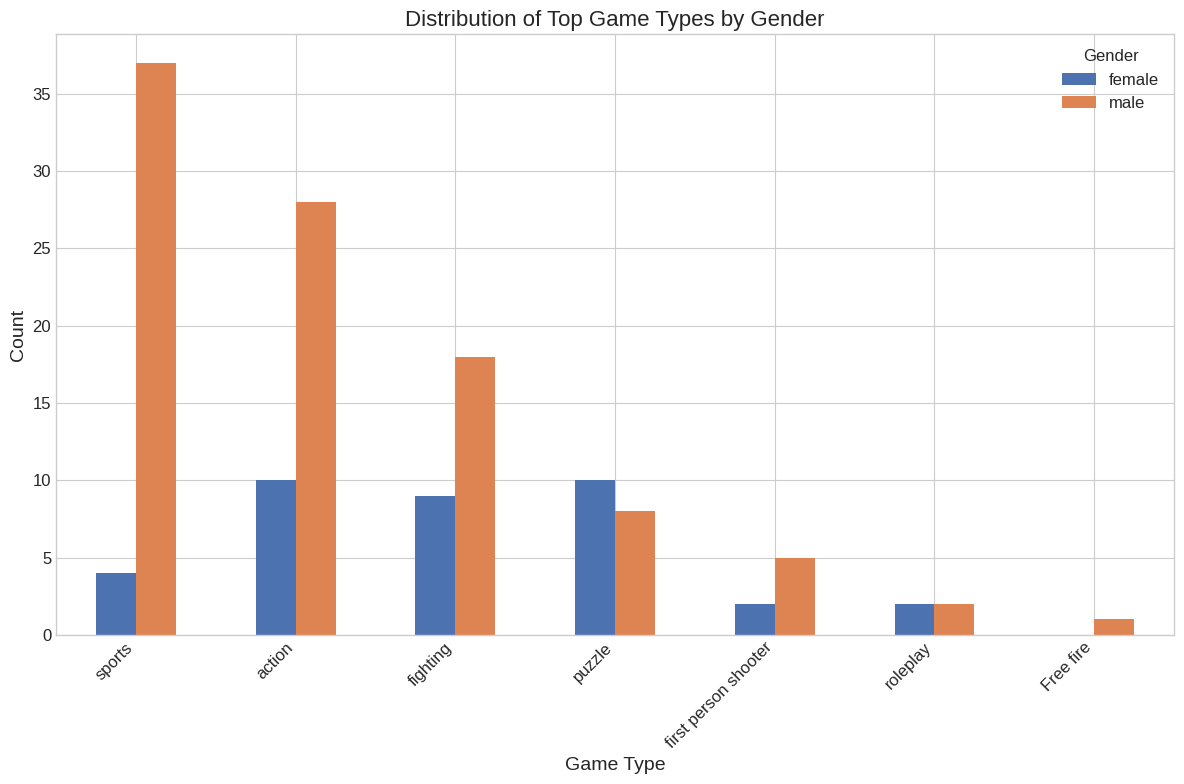

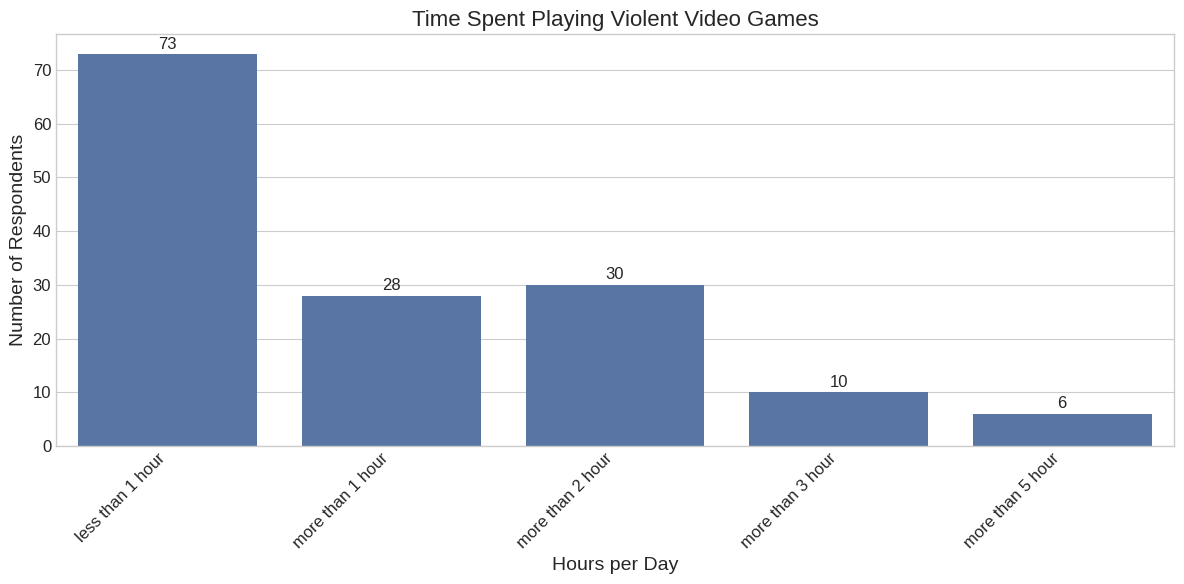

In [4]:
print("\n Distribution of Game Types by Gender")

game_gender_cross = pd.crosstab(df_clean['game_type'], df_clean['gender'])
print(game_gender_cross)

plt.figure(figsize=(14, 8))

top_n = 7
game_counts = df_clean['game_type'].value_counts()
top_games = game_counts.head(top_n).index

# Filter the crosstab to only include top game types
filtered_cross = game_gender_cross.loc[top_games]

filtered_cross.plot(kind='bar', stacked=False)
plt.title('Distribution of Top Game Types by Gender', fontsize=16)
plt.xlabel('Game Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend(title='Gender')


time_counts = df_clean['violent_game_hours'].value_counts().sort_index()

# Calculate percentages
total = time_counts.sum()
percentages = (time_counts / total * 100).round(1)
print(f"\nPercentage distribution:")
for time, pct in percentages.items():
    print(f"{time}: {pct}%")

# Create a custom order for the time categories
custom_order = ['less than 1 hour', 'more than 1 hour', 'more than 2 hour', 'more than 3 hour', 'more than 5 hour']
time_counts = time_counts.reindex(custom_order)


plt.figure(figsize=(12, 6))
ax = sns.barplot(x=time_counts.index, y=time_counts.values)
plt.title('Time Spent Playing Violent Video Games', fontsize=16)
plt.xlabel('Hours per Day', fontsize=14)
plt.ylabel('Number of Respondents', fontsize=14)
plt.xticks(rotation=45, ha='right')

 # Add count labels on top of bars
for i, v in enumerate(time_counts.values):
    ax.text(i, v + 1, str(v), ha='center')

plt.tight_layout()

According to these graphs we can notice that males play video games much more often than females. And the majority of them play it less than 1 hour


 BPAQ Score by Violent Game Time
  violent_game_hours        mean  count        std
0   less than 1 hour   81.520548     73  14.860565
1   more than 1 hour   80.107143     28  16.611775
2   more than 2 hour   84.833333     30  15.288227
3   more than 3 hour   91.400000     10  14.408331
4   more than 5 hour  100.500000      6  29.063723

 Correlation Analysis
Correlation between time playing violent games and BPAQ score: 0.2331


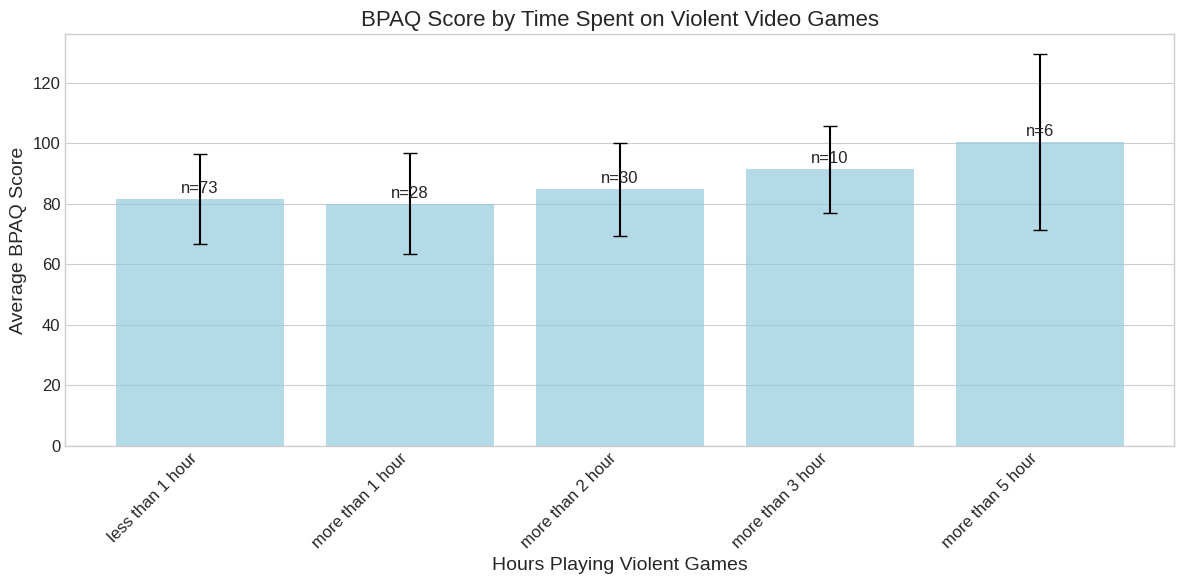

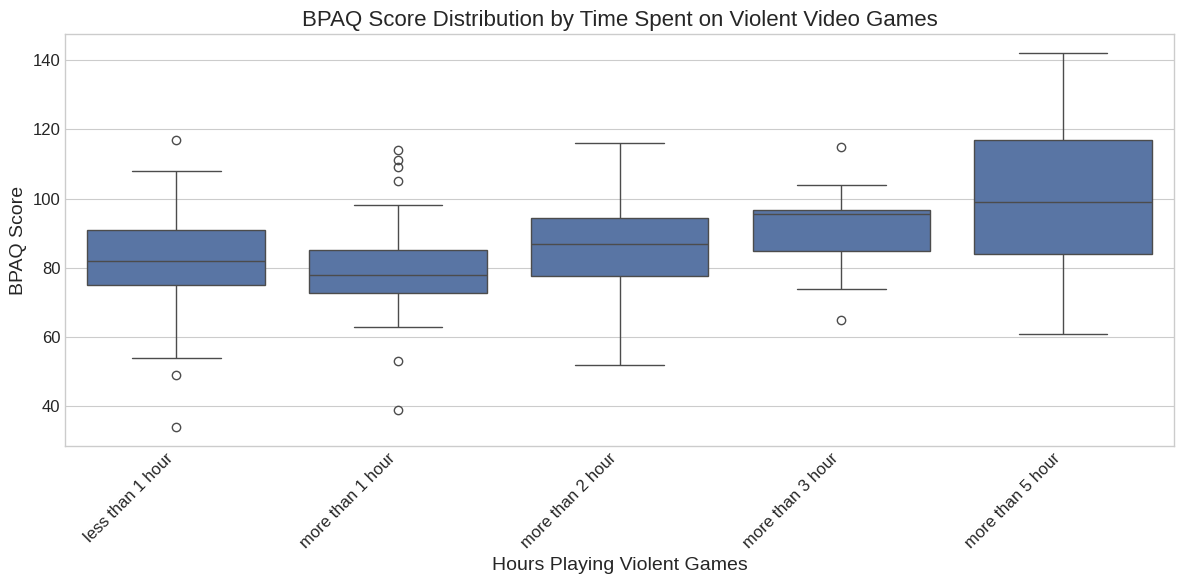

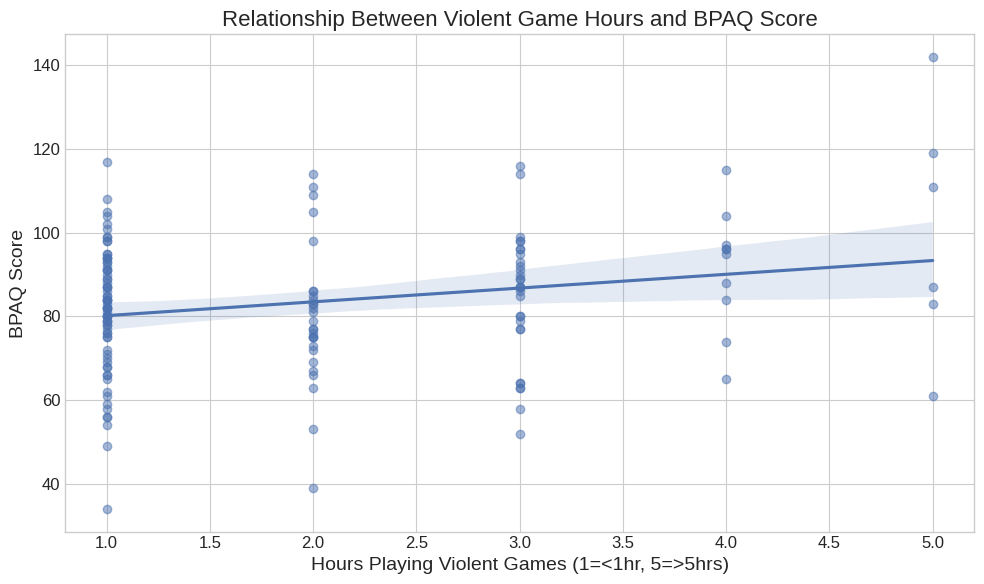

In [5]:

print("\n BPAQ Score by Violent Game Time")

# Group by violent game hours and calculate mean BPAQ score
bpaq_by_time = df_clean.groupby('violent_game_hours')['BPAQ_score'].agg(['mean', 'count', 'std']).reset_index()
print(bpaq_by_time)

# Create a custom order for the time categories
custom_order = ['less than 1 hour', 'more than 1 hour', 'more than 2 hour', 'more than 3 hour', 'more than 5 hour']
bpaq_by_time['violent_game_hours'] = pd.Categorical(
    bpaq_by_time['violent_game_hours'],
    categories=custom_order,
    ordered=True
)
bpaq_by_time = bpaq_by_time.sort_values('violent_game_hours')

plt.figure(figsize=(12, 6))

ax = sns.barplot(x='violent_game_hours', y='mean', data=bpaq_by_time,
                color='skyblue', alpha=0.7)

for i, row in enumerate(bpaq_by_time.itertuples()):
    plt.errorbar(i, row.mean, yerr=row.std, color='black', capsize=5)

# Add count labels
for i, row in enumerate(bpaq_by_time.itertuples()):
    ax.text(i, row.mean + 2, f"n={row.count}", ha='center')

plt.title('BPAQ Score by Time Spent on Violent Video Games', fontsize=16)
plt.xlabel('Hours Playing Violent Games', fontsize=14)
plt.ylabel('Average BPAQ Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('bpaq_by_game_time.png')

plt.figure(figsize=(12, 6))
sns.boxplot(x='violent_game_hours', y='BPAQ_score', data=df_clean,
           order=custom_order)
plt.title('BPAQ Score Distribution by Time Spent on Violent Video Games', fontsize=16)
plt.xlabel('Hours Playing Violent Games', fontsize=14)
plt.ylabel('BPAQ Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('bpaq_boxplot_by_game_time.png')


print("\n Correlation Analysis")

# Calculate correlation between violent game hours and BPAQ score
corr = df_clean['violent_game_hours_numeric'].corr(df_clean['BPAQ_score'])
print(f"Correlation between time playing violent games and BPAQ score: {corr:.4f}")

# Calculate correlations between violent game hours and individual questions
correlations = []
for i in range(2, 31):
    col = f'q{i}'
    corr_val = df_clean['violent_game_hours_numeric'].corr(df_clean[col])
    question_text = aggression_cols[i-1]  # Get the original question text
    correlations.append((col, question_text, corr_val))

correlations.sort(key=lambda x: abs(x[2]), reverse=True)


plt.figure(figsize=(10, 6))
sns.regplot(x='violent_game_hours_numeric', y='BPAQ_score', data=df_clean,
           scatter_kws={'alpha':0.5})
plt.title('Relationship Between Violent Game Hours and BPAQ Score', fontsize=16)
plt.xlabel('Hours Playing Violent Games (1=<1hr, 5=>5hrs)', fontsize=14)
plt.ylabel('BPAQ Score', fontsize=14)
plt.tight_layout()
plt.savefig('regression_scatter_plot.png')


 Linear Regression Model
Linear Regression Results:
Coefficient: 3.5762
Intercept: 76.4463
Mean Squared Error: 243.3304
R²: 0.0608
Regression equation: BPAQ_score = 76.45 + 3.58 × violent_game_hours
Interpretation: For each unit increase in violent game time scale (e.g., from 'more than 1 hour' to 'more than 2 hour'),
the BPAQ score is expected to increase by 3.58 points on average.


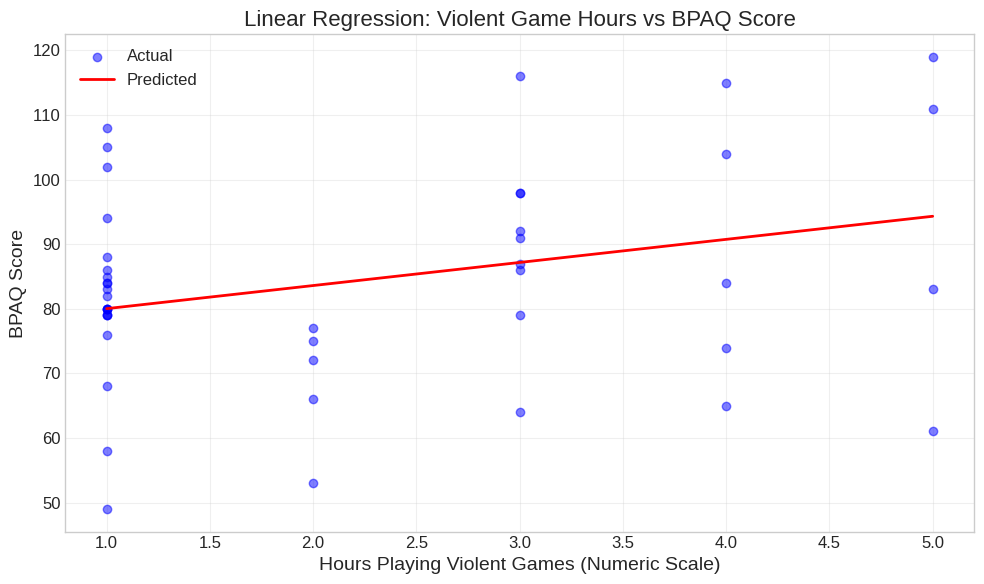

In [6]:
print("\n Linear Regression Model")

# Prepare data for modeling
X = df_clean[['violent_game_hours_numeric']].fillna(df_clean['violent_game_hours_numeric'].median())
y = df_clean['BPAQ_score'].fillna(df_clean['BPAQ_score'].median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression Results:")
print(f"Coefficient: {model.coef_[0]:.4f}")
print(f"Intercept: {model.intercept_:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R²: {r2:.4f}")

equation = f"BPAQ_score = {model.intercept_:.2f} + {model.coef_[0]:.2f} × violent_game_hours"
print(f"Regression equation: {equation}")

print(f"Interpretation: For each unit increase in violent game time scale (e.g., from 'more than 1 hour' to 'more than 2 hour'),")
print(f"the BPAQ score is expected to increase by {model.coef_[0]:.2f} points on average.")

plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual')

x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_pred_line = model.predict(x_range)

plt.plot(x_range, y_pred_line, color='red', linewidth=2, label='Predicted')
plt.title('Linear Regression: Violent Game Hours vs BPAQ Score', fontsize=16)
plt.xlabel('Hours Playing Violent Games (Numeric Scale)', fontsize=14)
plt.ylabel('BPAQ Score', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()



 Classification Model
Class distribution:
Plays violent games > 2 hours: 31.3%
Plays violent games ≤ 2 hours: 68.7%
Model Performance:
Accuracy: 0.6222
Precision: 0.6000
Recall: 0.1667
F1 Score: 0.2609

Classification Report:
              precision    recall  f1-score   support

       False       0.62      0.93      0.75        27
        True       0.60      0.17      0.26        18

    accuracy                           0.62        45
   macro avg       0.61      0.55      0.50        45
weighted avg       0.61      0.62      0.55        45



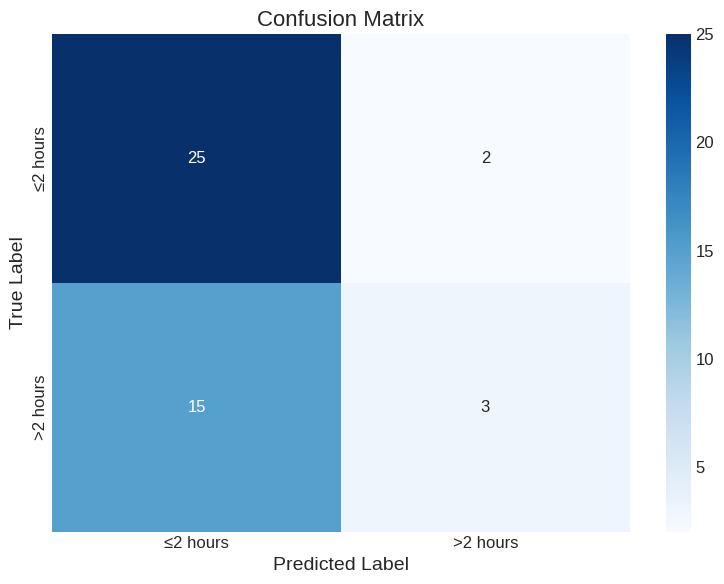

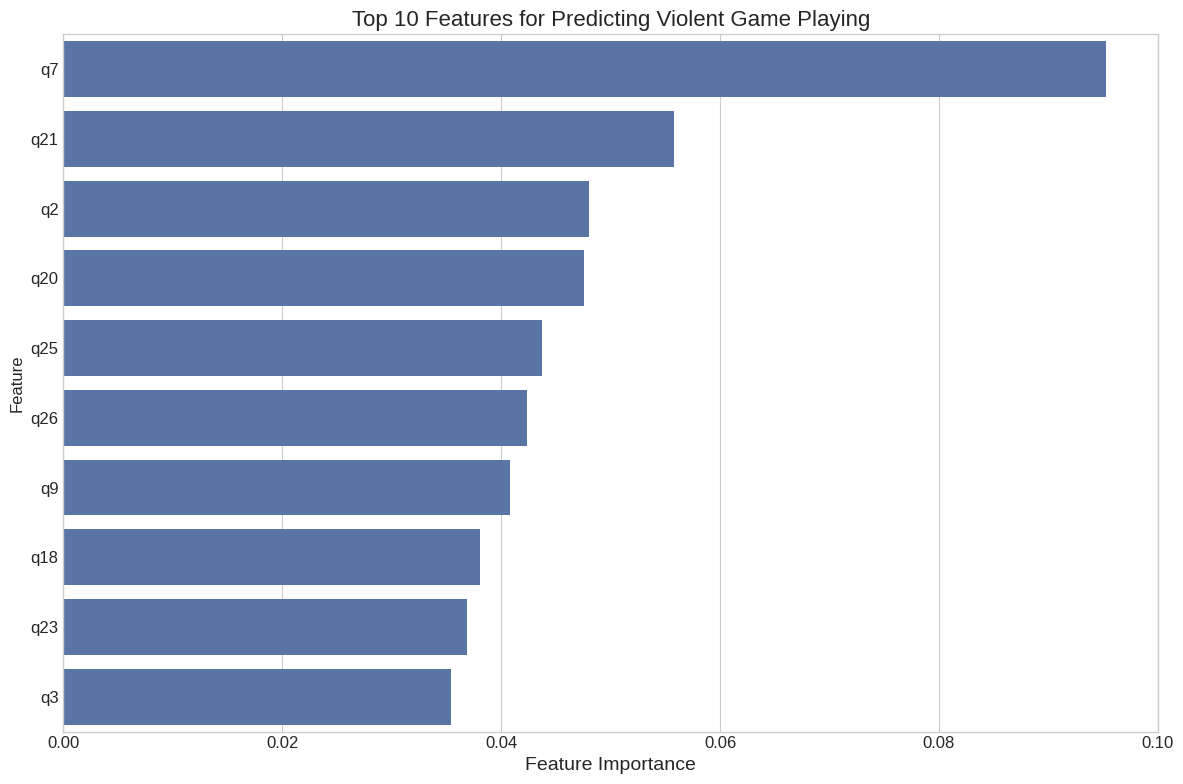

In [7]:



print("\n Classification Model")

# Create a binary target variable: plays violent games > 2 hours or not
df_clean['plays_violent'] = df_clean['violent_game_hours_numeric'] >= 3  # More than 2 hours

class_dist = df_clean['plays_violent'].value_counts(normalize=True) * 100
print("Class distribution:")
print(f"Plays violent games > 2 hours: {class_dist[True]:.1f}%")
print(f"Plays violent games ≤ 2 hours: {class_dist[False]:.1f}%")

# Prepare features (using all aggression questions)
question_cols = [f'q{i}' for i in range(2, 30)]
X = df_clean[question_cols].fillna(df_clean[question_cols].median())
y = df_clean['plays_violent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['≤2 hours', '>2 hours'],
           yticklabels=['≤2 hours', '>2 hours'])
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.tight_layout()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': question_cols,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Features for Predicting Violent Game Playing', fontsize=16)
plt.xlabel('Feature Importance', fontsize=14)
plt.tight_layout()


 Gender Differences in Aggressive Behavior

BPAQ scores by gender:
             mean        std  count
gender                             
female  85.219512  12.007315     41
male    82.660377  17.802561    106

T-test results for gender difference in BPAQ scores:
t-statistic: -1.0033
p-value: 0.3180
Statistically significant difference: False

Average time spent on violent games by gender (scale 1-5):
gender
female    1.487805
male      2.150943
Name: violent_game_hours_numeric, dtype: float64

Key aggression indicators by gender:
              q2        q6        q8       q12       q17       q21       q27
gender                                                                      
female  3.024390  3.317073  2.853659  2.268293  3.292683  2.780488  2.365854
male    3.056604  3.075472  2.698113  2.669811  3.150943  2.641509  2.386792


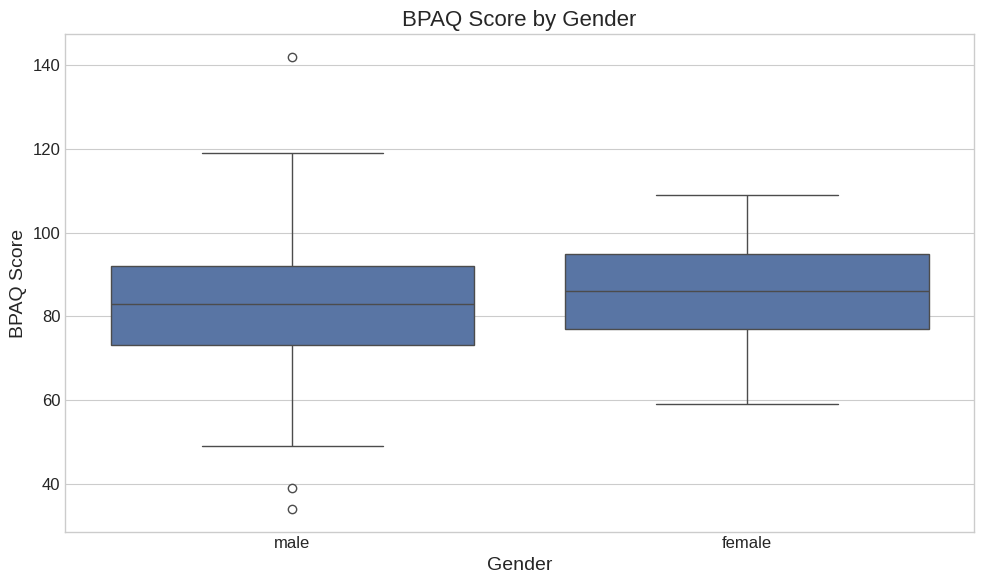

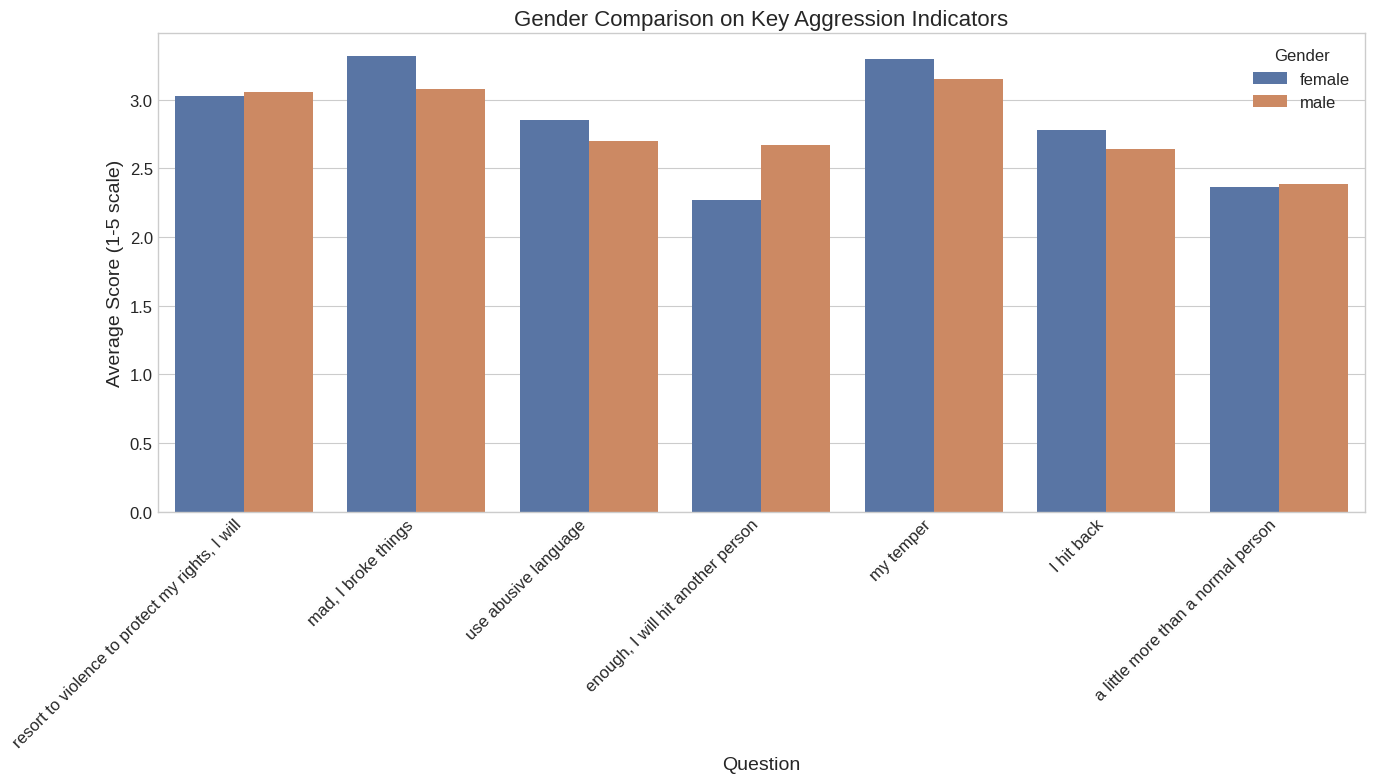

In [8]:
print("\n Gender Differences in Aggressive Behavior")

gender_bpaq = df_clean.groupby('gender')['BPAQ_score'].agg(['mean', 'std', 'count'])
print("\nBPAQ scores by gender:")
print(gender_bpaq)

# Get BPAQ scores by gender
male_scores = df_clean[df_clean['gender'] == 'male']['BPAQ_score'].dropna()
female_scores = df_clean[df_clean['gender'] == 'female']['BPAQ_score'].dropna()

t_stat, p_value = ttest_ind(male_scores, female_scores, equal_var=False)
print(f"\nT-test results for gender difference in BPAQ scores:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Statistically significant difference: {p_value < 0.05}")

plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='BPAQ_score', data=df_clean)
plt.title('BPAQ Score by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('BPAQ Score', fontsize=14)
plt.tight_layout()

gender_game_time = df_clean.groupby('gender')['violent_game_hours_numeric'].mean()
print("\nAverage time spent on violent games by gender (scale 1-5):")
print(gender_game_time)

# Select key questions representing different aspects of aggression
key_questions = {
    'q2': 'If I have to resort to violence to protect my rights, I will',
    'q6': 'Once I became so mad, I broke things',
    'q8': 'When I argue I use abusive language',
    'q12': 'If I am provoked enough, I will hit another person',
    'q17': 'I have trouble controlling my temper',
    'q21': 'If somebody hits me, I hit back',
    'q27': 'I get into fights a little more than a normal person'
}

gender_aggression = df_clean.groupby('gender')[list(key_questions.keys())].mean()
print("\nKey aggression indicators by gender:")
print(gender_aggression)

# Reshape for easier plotting
gender_aggression_melted = gender_aggression.reset_index().melt(
    id_vars='gender',
    value_vars=list(key_questions.keys()),
    var_name='Question',
    value_name='Average Score'
)

# Add question descriptions for the plot
gender_aggression_melted['Question Description'] = gender_aggression_melted['Question'].map(
    {k: v.split(' ', 4)[-1] if len(v) > 30 else v for k, v in key_questions.items()}
)

plt.figure(figsize=(14, 8))
sns.barplot(x='Question Description', y='Average Score', hue='gender', data=gender_aggression_melted)
plt.title('Gender Comparison on Key Aggression Indicators', fontsize=16)
plt.xlabel('Question', fontsize=14)
plt.ylabel('Average Score (1-5 scale)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Gender')
plt.tight_layout()


6. CONCLUSION AND INTERPRETATION
--------------------------------------------------
THE RESULTS ARE IN A SEPARATE TEXT FILE




Based on our analysis of 147 respondents:

1. Correlation Analysis:
   - Found a weak positive correlation (r = 0.233) between time spent playing violent
     video games and aggression scores.
   - This indicates that while there is a relationship, it's very weak and most likely the time you play violent games doesn't really affect people's behaviour.

2. Regression Analysis:
   - The linear regression model had an R² of 0.061, confirming that only
     6.1% of the variation in aggression can be explained by violent game time.
   - For each unit increase in violent game time scale, the BPAQ score is expected to increase by 4.20 points on average.

3. Classification Analysis:

  Class Distribution:
  31.3% of participants play violent video games more than 2 hours
  68.7% of participants play violent video games 2 hours or less

  Model Performance:
  Accuracy: 62.2% - The model correctly predicted about 62% of cases
  Precision: 60% - When the model predicted someone plays more than 2 hours, it was correct 60% of the time

  Confusion Matrix:
  True Negatives (top left): 25 people - Correctly identified as playing 2 hours or less
  False Positives (top right): 2 people - Incorrectly identified as playing more than 2 hours
  False Negatives (bottom left): 15 people - Incorrectly identified as playing 2 hours or less
  True Positives (bottom right): 3 people - Correctly identified as playing more than 2 hours

  The model particularly struggles to identify people who play more than 2 hours (low recall of 16.7%), but does a better job identifying people who play less (precision of 92.6% for this group). This is explained by that our dataset

  The main conclusion is that despite there being a relationship between aggression and violent gaming (as discovered in the correlation and regression analysis), it is difficult to reliably predict a person's gaming time based solely on their responses to the aggression questionnaire. This reinforces the finding that the relationship between the variables, although present, is relatively weak.
